In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model,load_model
import keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from tensorflow.keras.optimizers import Adam
#import tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
#from tensorflow.python.keras.optimizers import Adam
tf.random.set_seed(123)
from tensorflow.python.keras import backend as K
# from keras import backend as K
from tensorflow.keras.models import Sequential
session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf =  tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#sess = tf.Session(graph=tf.default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
print(os.listdir())

['.ipynb_checkpoints', '.vscode', 'bobframes', 'bob_hall_pier.MP4', 'cape_cod_edit.mp4', 'cframes', 'cmasks', 'earlierTests', 'frames', 'images', 'labelme_json_to_png-master', 'readme.txt', 'removeFOLDERS.txt', 'Research__Seashore_Detection.pdf', 'saveFramesofVideos.ipynb', 'TLtest.ipynb', 'Untitled.ipynb', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']


In [3]:
print(os.getcwd())
os.chdir(r'images/mask')
print(os.getcwd())

C:\Users\k v\Documents\REU\ShorelineDetection
C:\Users\k v\Documents\REU\ShorelineDetection\images\mask


In [4]:
pic = cv2.imread('cod_0.png')

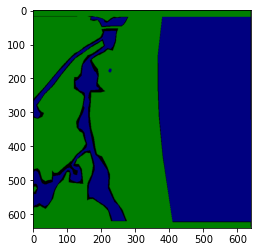

In [5]:
plt.imshow(pic)

In [6]:
print(os.getcwd())


C:\Users\k v\Documents\REU\ShorelineDetection\images\mask


In [7]:
path= (r'C:/Users/k v/Documents/REU/ShorelineDetection/images/')

In [8]:
print(os.listdir(path+'train'))

['cod_0.jpg', 'cod_100.jpg', 'cod_1000.jpg', 'cod_1050.jpg', 'cod_1100.jpg', 'cod_1150.jpg', 'cod_1200.jpg', 'cod_1250.jpg', 'cod_1300.jpg', 'cod_1350.jpg', 'cod_1400.jpg', 'cod_1450.jpg', 'cod_150.jpg', 'cod_200.jpg', 'cod_250.jpg', 'cod_300.jpg', 'cod_350.jpg', 'cod_400.jpg', 'cod_450.jpg', 'cod_50.jpg', 'cod_500.jpg', 'cod_550.jpg', 'cod_600.jpg', 'cod_650.jpg', 'cod_700.jpg', 'cod_750.jpg', 'cod_800.jpg', 'cod_850.jpg', 'cod_900.jpg', 'cod_950.jpg']


In [9]:
print(os.listdir(path+'mask'))

['cod_0.png', 'cod_100.png', 'cod_1000.png', 'cod_1050.png', 'cod_1100.png', 'cod_1150.png', 'cod_1200.png', 'cod_1250.png', 'cod_1300.png', 'cod_1350.png', 'cod_1400.png', 'cod_1450.png', 'cod_150.png', 'cod_200.png', 'cod_250.png', 'cod_300.png', 'cod_350.png', 'cod_400.png', 'cod_450.png', 'cod_50.png', 'cod_500.png', 'cod_550.png', 'cod_600.png', 'cod_650.png', 'cod_700.png', 'cod_750.png', 'cod_800.png', 'cod_850.png', 'cod_900.png', 'cod_950.png']


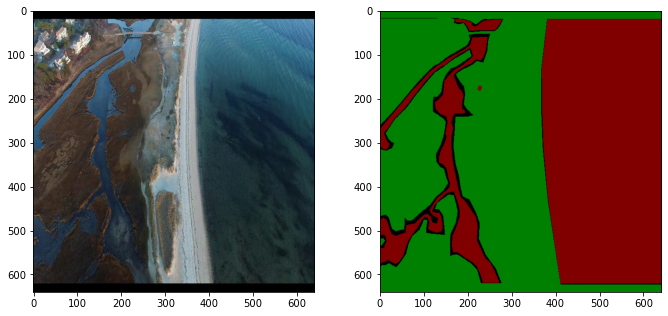

In [10]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img = cv2.imread(path+"train/cod_0.jpg")  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.subplot(5,5,1+1)
img = cv2.imread(path+"mask/cod_0.png")  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
# plt.subplot(5,5,1+2)
# img = cv.imread(InputPath+"clean/clean0001.png")  
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# plt.imshow(img)


In [11]:
c = sorted(os.listdir(path+'train'))
d = sorted(os.listdir(path+'mask'))
print(len(d))
print(len(c))

30
30


In [12]:
def ExtractData(path):
    SourceImg = sorted(os.listdir(path+'train'))
    TargetImg = sorted(os.listdir(path+'mask'))
    X_=[]
    y_=[]
    count=0
    for i in range(len(SourceImg)):
        if count<2165:
            count=count+1
            img_1 = cv2.imread(path+'train/'+SourceImg[i])
            img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
            img_1 = cv2.resize(img_1,(500,500))
            X_.append(img_1)
            img_2 = cv2.imread(path+'mask/'+TargetImg[i])
            img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
            img_2 = cv2.resize(img_2,(500,500))
            y_.append(img_2)
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [13]:
X_,y_ = ExtractData(path)

In [14]:
y_.shape


(30, 500, 500, 3)

In [15]:
X_.shape

(30, 500, 500, 3)

In [16]:
input_shape = (500, 500, 3)
VGG16_weight = "../vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

print('Model loaded.')

Model loaded.


In [17]:
output_ = VGG16.output
output_

<tf.Tensor 'block5_pool_1/Identity:0' shape=(None, 15, 15, 512) dtype=float32>

In [18]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [19]:
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_2,True
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,True


In [20]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [21]:
K.clear_session()
def ModelEnhancer():
    input_shape = (500, 500, 3)
#     VGG16_weight = "../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
#     VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
    VGG16=tf.keras.applications.VGG16( input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
            
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)    
    
    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Model(VGG16.input,model_)
    
    return model_

In [22]:
Model_ = ModelEnhancer()
Model_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 500, 500, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 500, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 250, 250, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [23]:
# from keras.utils.vis_utils import plot_model
# plot_model(Model_,to_file=path+"model_.png",show_shapes=True, show_layer_names=True)
# from IPython.display import Image
# Image(retina=True, filename='model_.png')


In [24]:
Model_.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
#Adam(lr = 1e-4)

In [25]:
checkpointer = ModelCheckpoint('model_TL_UNET.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

In [26]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_.fit(GenerateInputs(X_,y_),epochs=10,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True)

  ...
    to  
  ['...']
Train for 2 steps
Epoch 1/10
1/2 [==============>...............] - ETA: 8s - loss: 106.6662 - accuracy: 0.5620
Epoch 00001: loss improved from inf to 93.03638, saving model to model_TL_UNET.h5
2/2 [==============================] - 10s 5s/step - loss: 93.0364 - accuracy: 0.5627
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 34.0695 - accuracy: 0.5809
Epoch 00002: loss improved from 93.03638 to 32.12779, saving model to model_TL_UNET.h5
2/2 [==============================] - 1s 479ms/step - loss: 32.1278 - accuracy: 0.5845
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 46.7445 - accuracy: 0.5875
Epoch 00003: loss did not improve from 32.12779
2/2 [==============================] - 0s 202ms/step - loss: 46.5265 - accuracy: 0.5871
Epoch 4/10
1/2 [==============>...............] - ETA: 0s - loss: 47.9721 - accuracy: 0.5838
Epoch 00004: loss did not improve from 32.12779
2/2 [==============================] - 0s 202ms/step - lo

In [27]:
TransferLearningModel = load_model('model_TL_UNET.h5')

In [28]:
img_x = cv2.imread(path + "valid/bob_0.jpg")
img_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2RGB)
img_x = cv2.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)

In [29]:
prediction = TransferLearningModel.predict(img_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


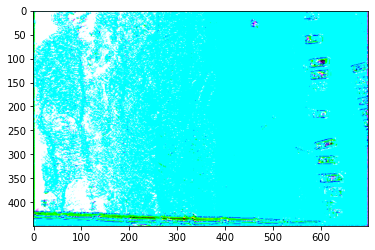

In [30]:
pred = prediction.reshape(500,500,3)
pred_ = cv2.resize(pred,(700,450))
plt.imshow(pred_)

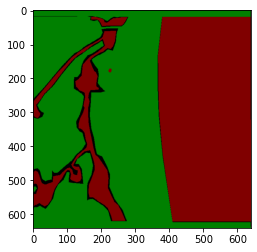

In [31]:
img = cv2.imread(path+"mask/cod_0.png")  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


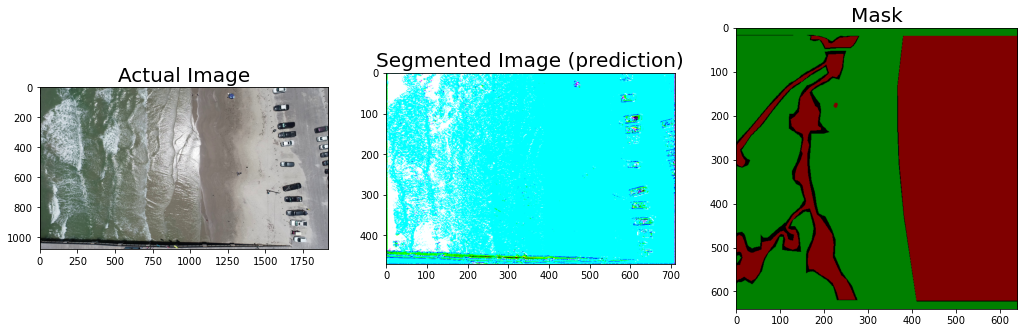

In [32]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_0 = cv2.imread(path+"valid/bob_0.jpg")  
image_0 = cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_0)
image_0 = cv2.resize(image_0,(500,500))
image_0 = image_0.reshape(1,500,500,3)
prediction_0 = TransferLearningModel.predict(image_0)
pred_0 = prediction_0.reshape(500,500,3)
pred_0 = cv2.resize(pred_0,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image (prediction)",fontsize=20)
plt.imshow(pred_0)
plt.subplot(5,5,1+2)
img_g0 = cv2.imread(path+"mask/cod_0.png")  #I DID NOT HAVE MASK FOR THIS
img_g0 = cv2.cvtColor(img_g0, cv2.COLOR_BGR2RGB)
plt.title("Mask",fontsize=20)
plt.imshow(img_g0)